# Introduction

## Determining a mid-pandemic initial condition in the national model

In order to establish a good calibration, a good initial condition has to be established. This implies, ideally, that we know ...

- For every metapopulation state,
- For every age class, and
- For every region

... how many subjects are in it at the start time of the calibration. For the start of the pandemic, the spectrum of choices is rather limited, because it only depends on how many and where people are in the Exposed state. Deciding on the initial condition of calibrations starting in the middle of the pandemic is more difficult.

It is _not_ sufficient just to know how many people are hospitalised, because the content of other states in the future of the simulation is determined by the content of previous states, through the coupled differential equations. We could estimate the content of all other states, but this is difficult and imprecise.

Instead, we will rely on the outcome of a previous calibration, given that this calibration neatly describes the data. This results in an initial condition that must resemble reality - otherwise it wouldn't have described the data in the past so well. If, however, the best-fit calibration result does not ideally describe the data, one could manually adjust the time-dependent social contact behaviour until a near-perfect match is made. (Note: the reason this is not done in the calibration itself, is because it doesn't really teach the user much.)

For the national model, this may be a tedious but certainly not a difficult excercise. For the spatially explicit model, things get more complicated, because just playing around with the social contact behaviour will not suffice to get all $G$ time series to more or less fit the data. See e.g. the time series for Belgium, Brussels and Antwerp (from the same manual fiddling):

## Demonstrating the IC problem for the spatially explicit model

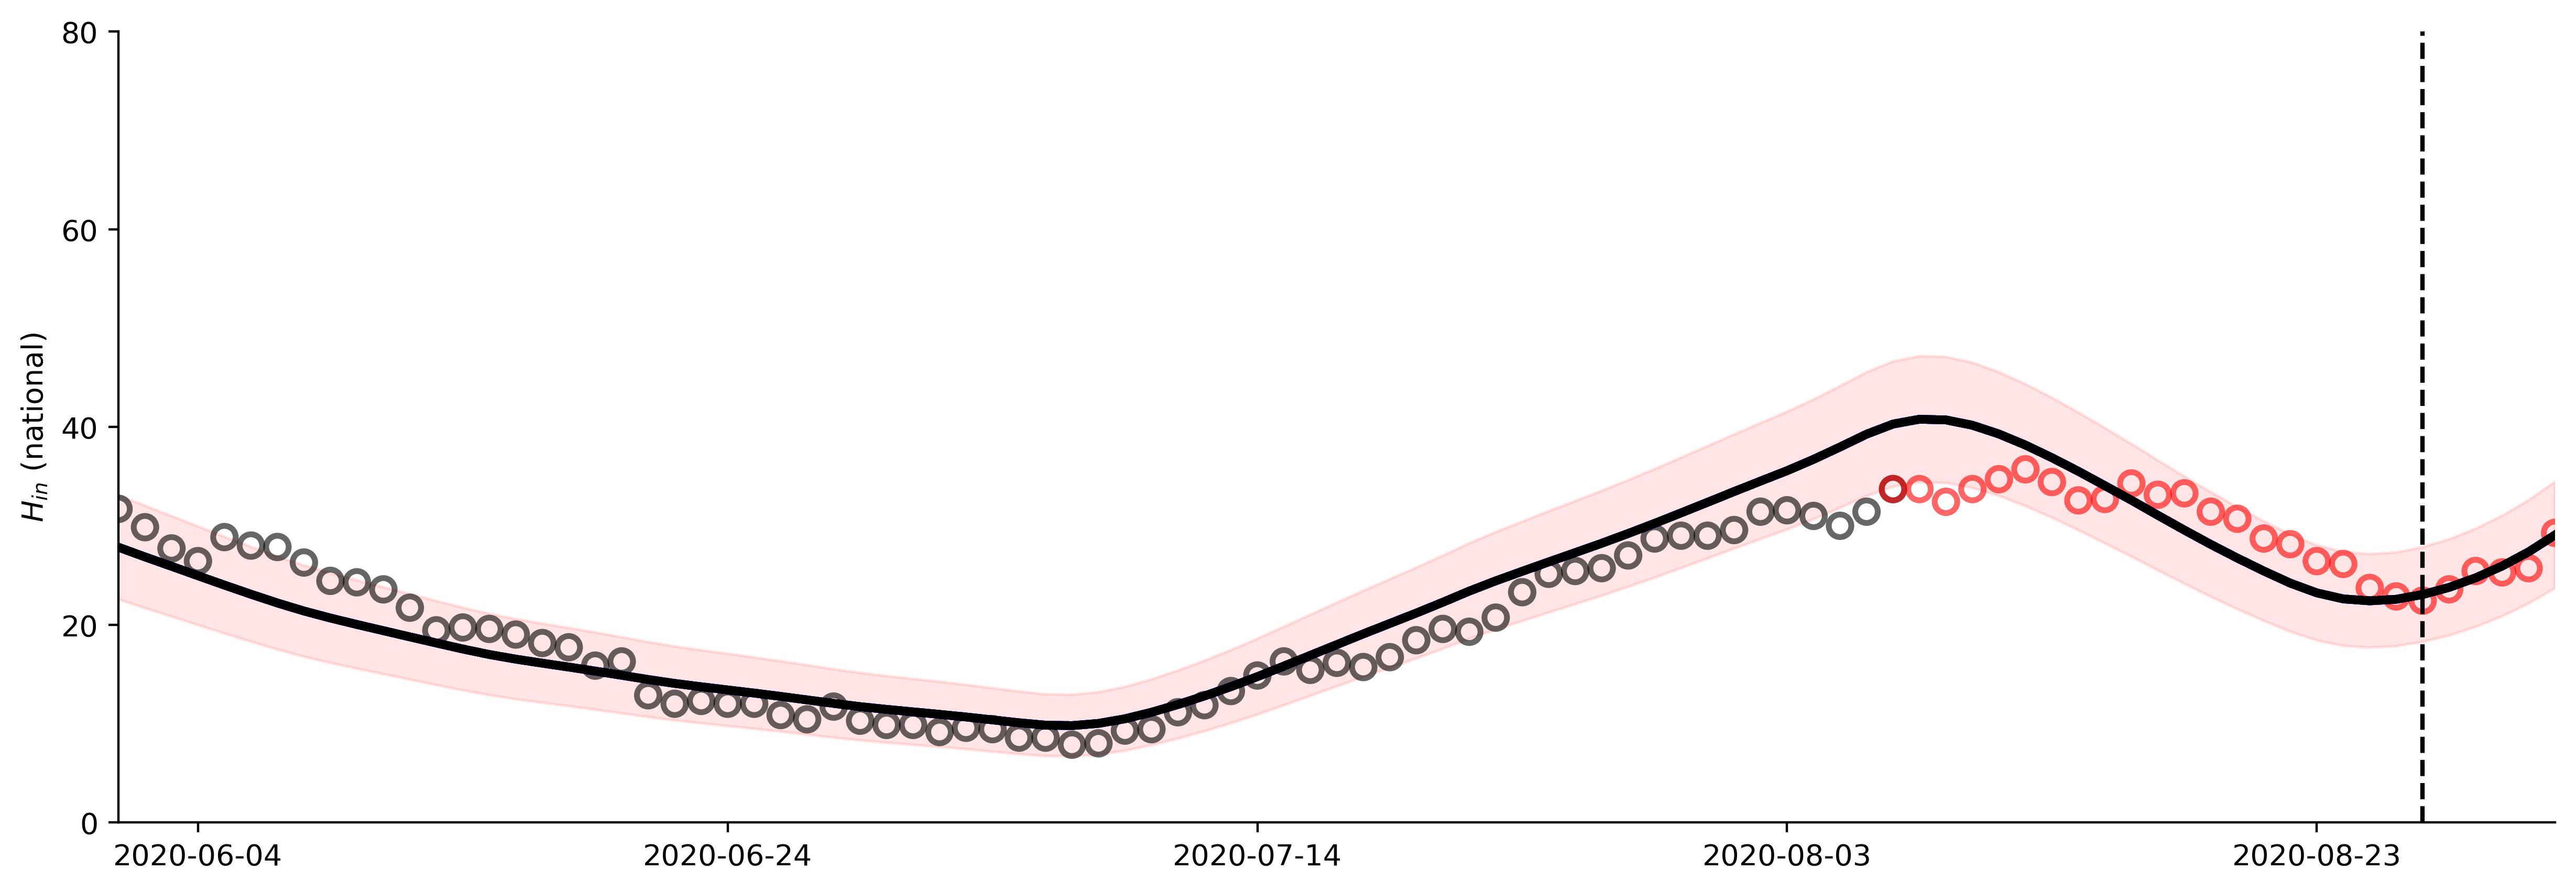

In [11]:
# The national data fit rather well

from IPython.display import Image
Image(filename='../calibration/summer-bump_national.png')

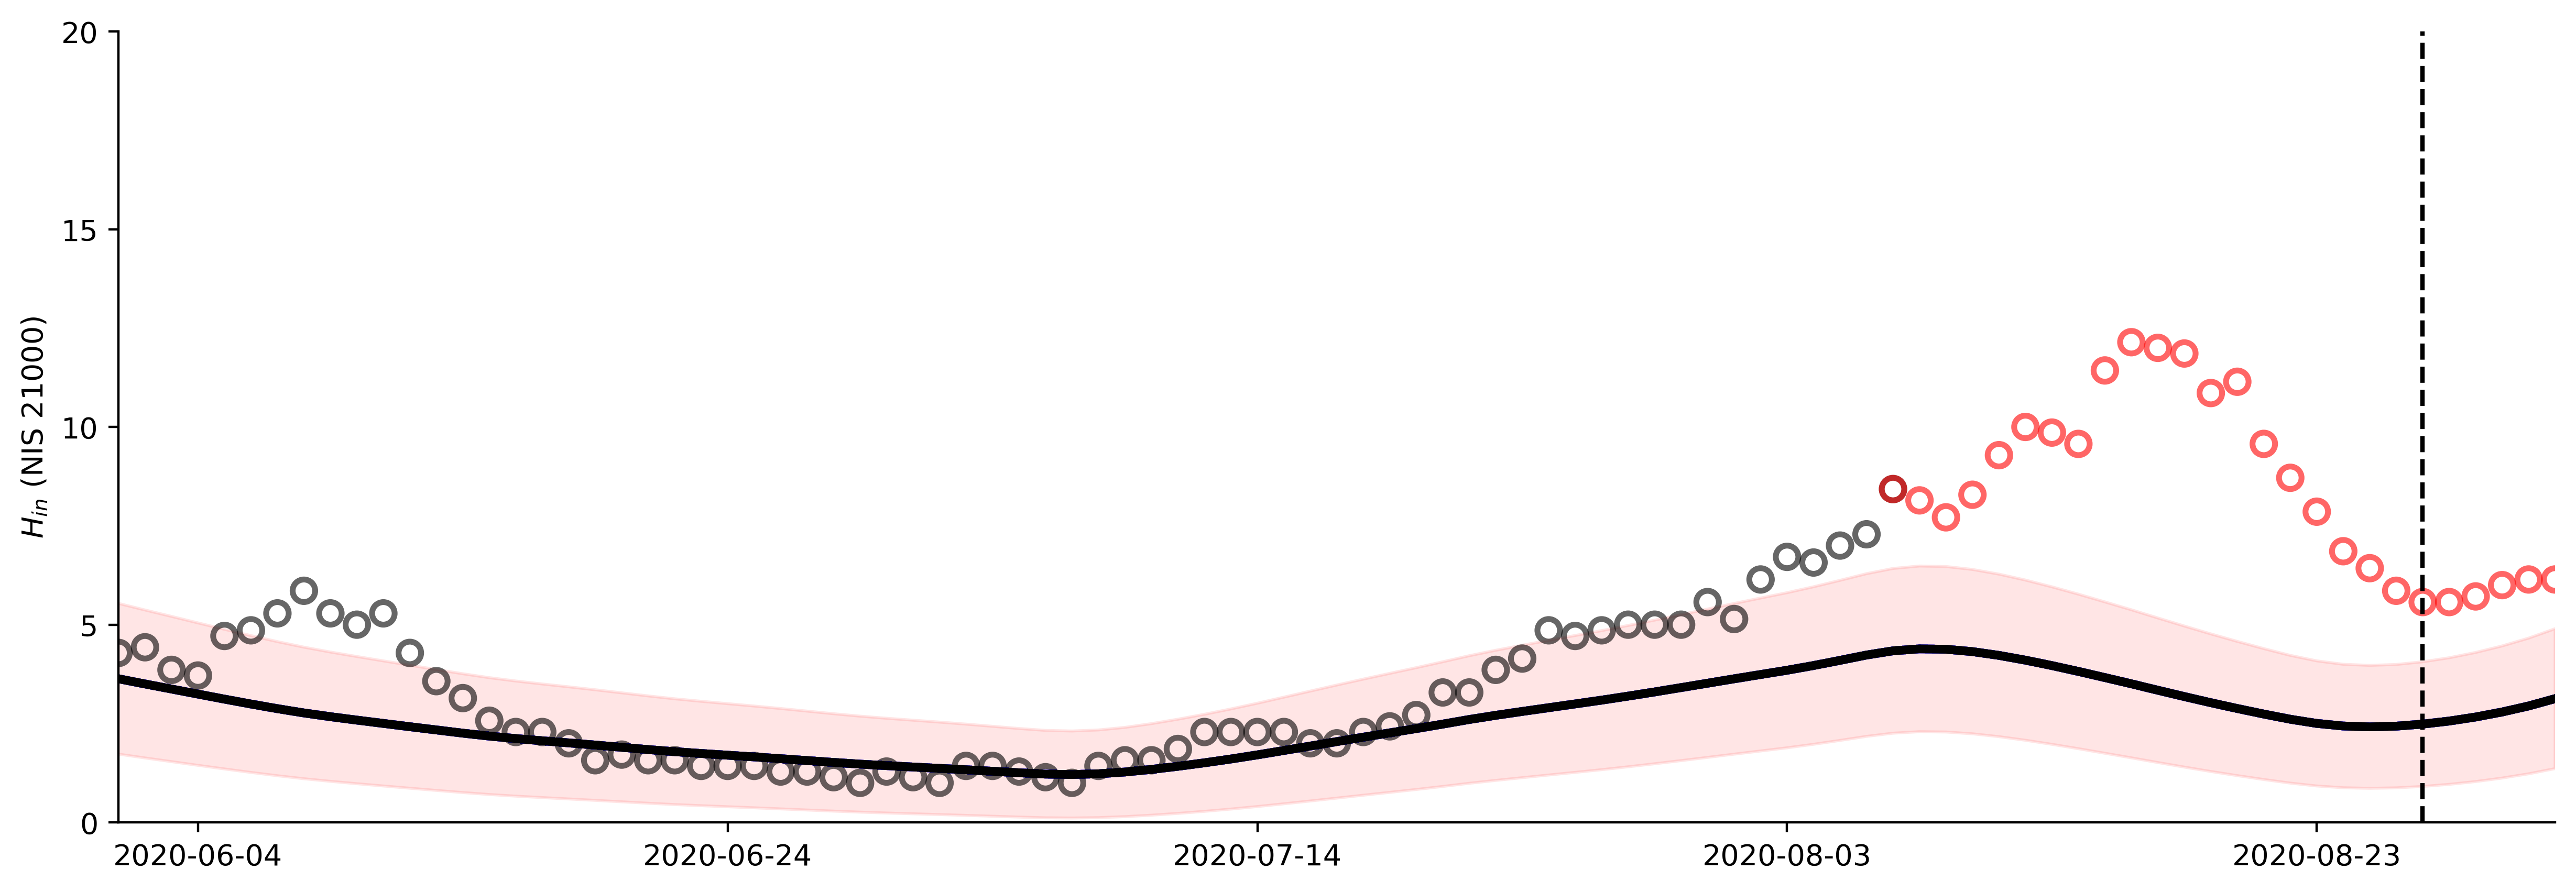

In [12]:
# The local data (Brussels) fit rather poorly

Image(filename='../calibration/summer-bump_21000.png')

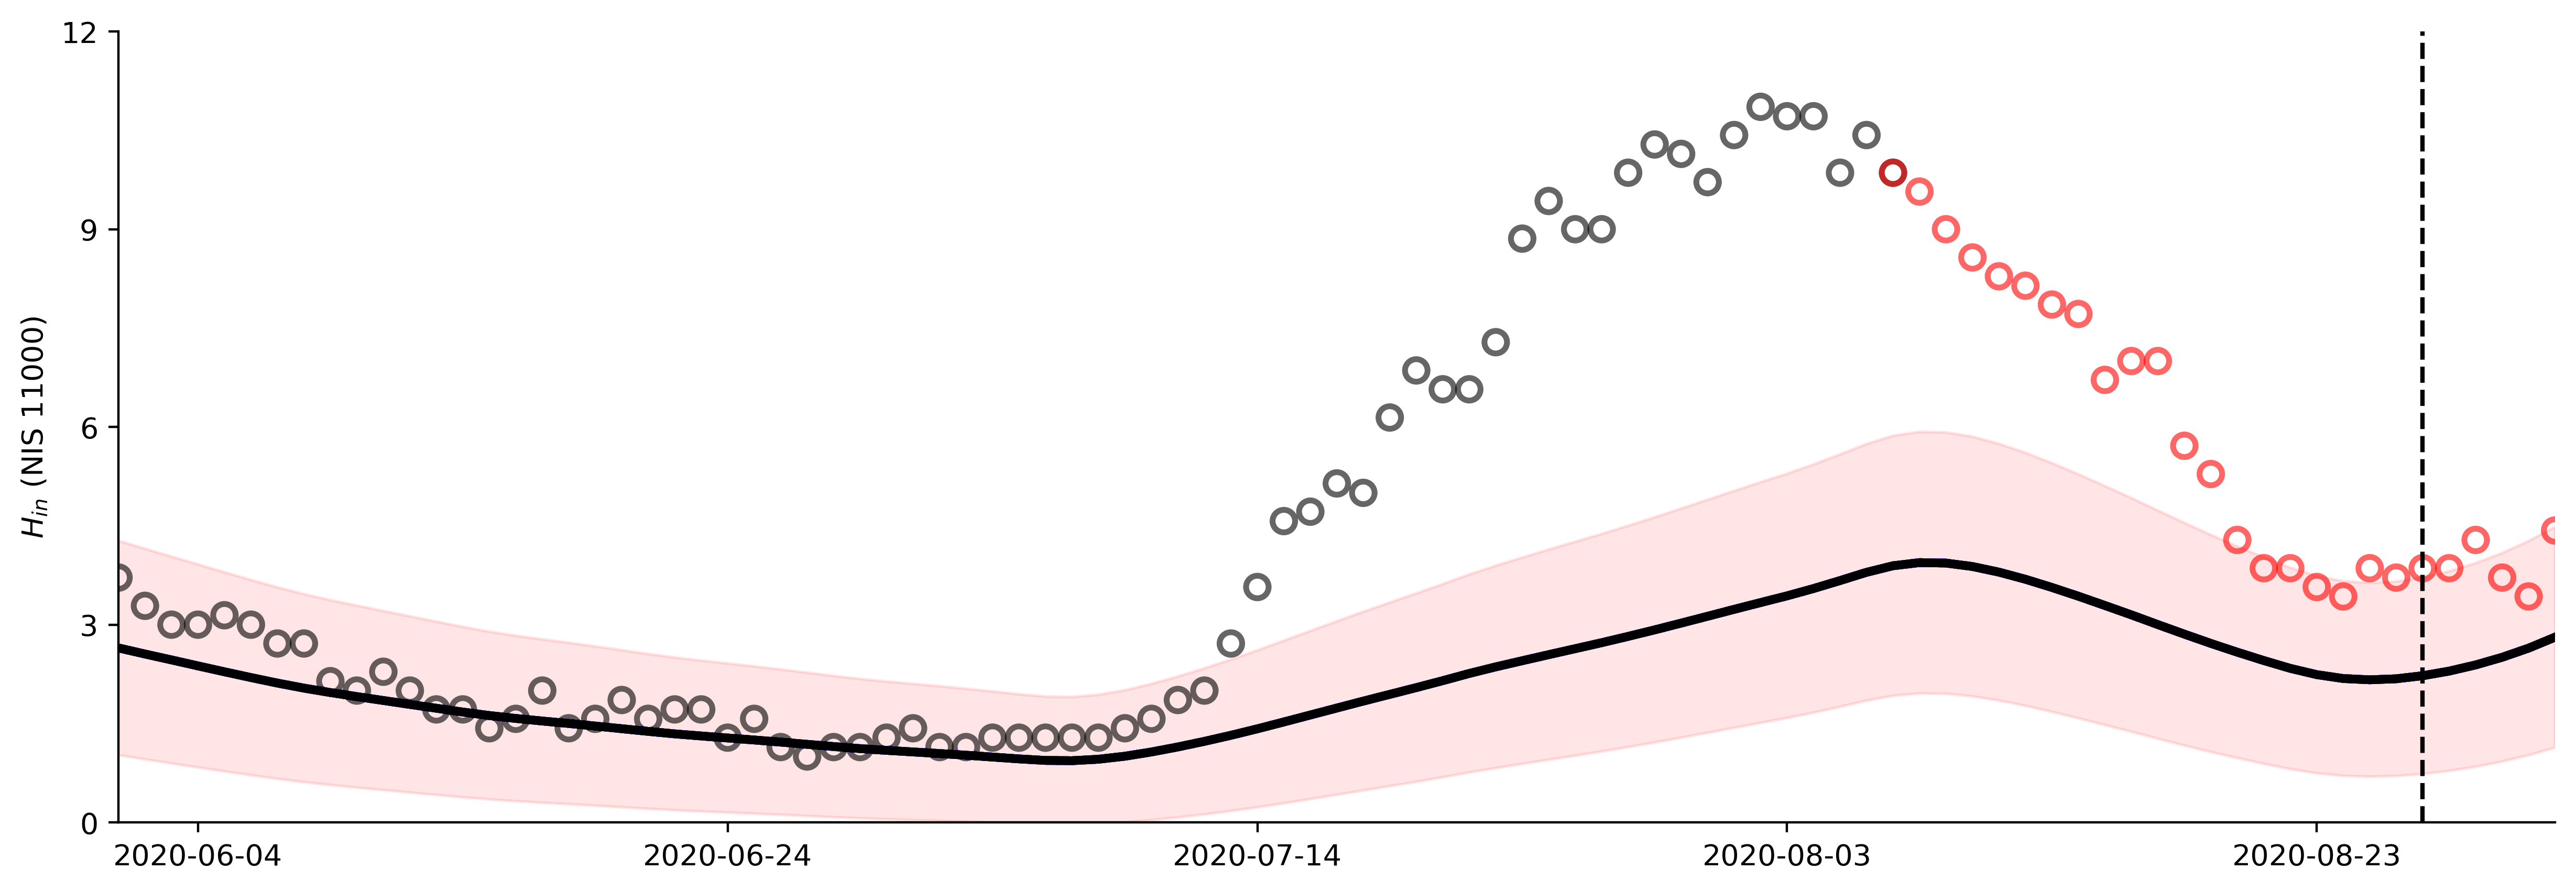

In [13]:
# The local data (Antwerp) fit rather poorly

Image(filename='../calibration/summer-bump_11000.png')

In order to create a proper calibration starting at the dashed vertical line in the figures above, it is particularly important to have the fit line pass the data _at that point_. This is very neatly the case for the nationally aggregated data/simulation, but not at all for the local time series.

This needs to be addressed, if we desire to initiate a good calibration for the ascending part of the future wave. The reason for that is easily understood: if the initial condition contains significantly fewer hospitalised subjects, an acceptable fit can only be achieved if the simulation line is 'brought up' by favouring a high transmission rate constant $\beta$. This high $\beta$ will then result in extrapolations (predictions) that far surpass the actual data. See below:

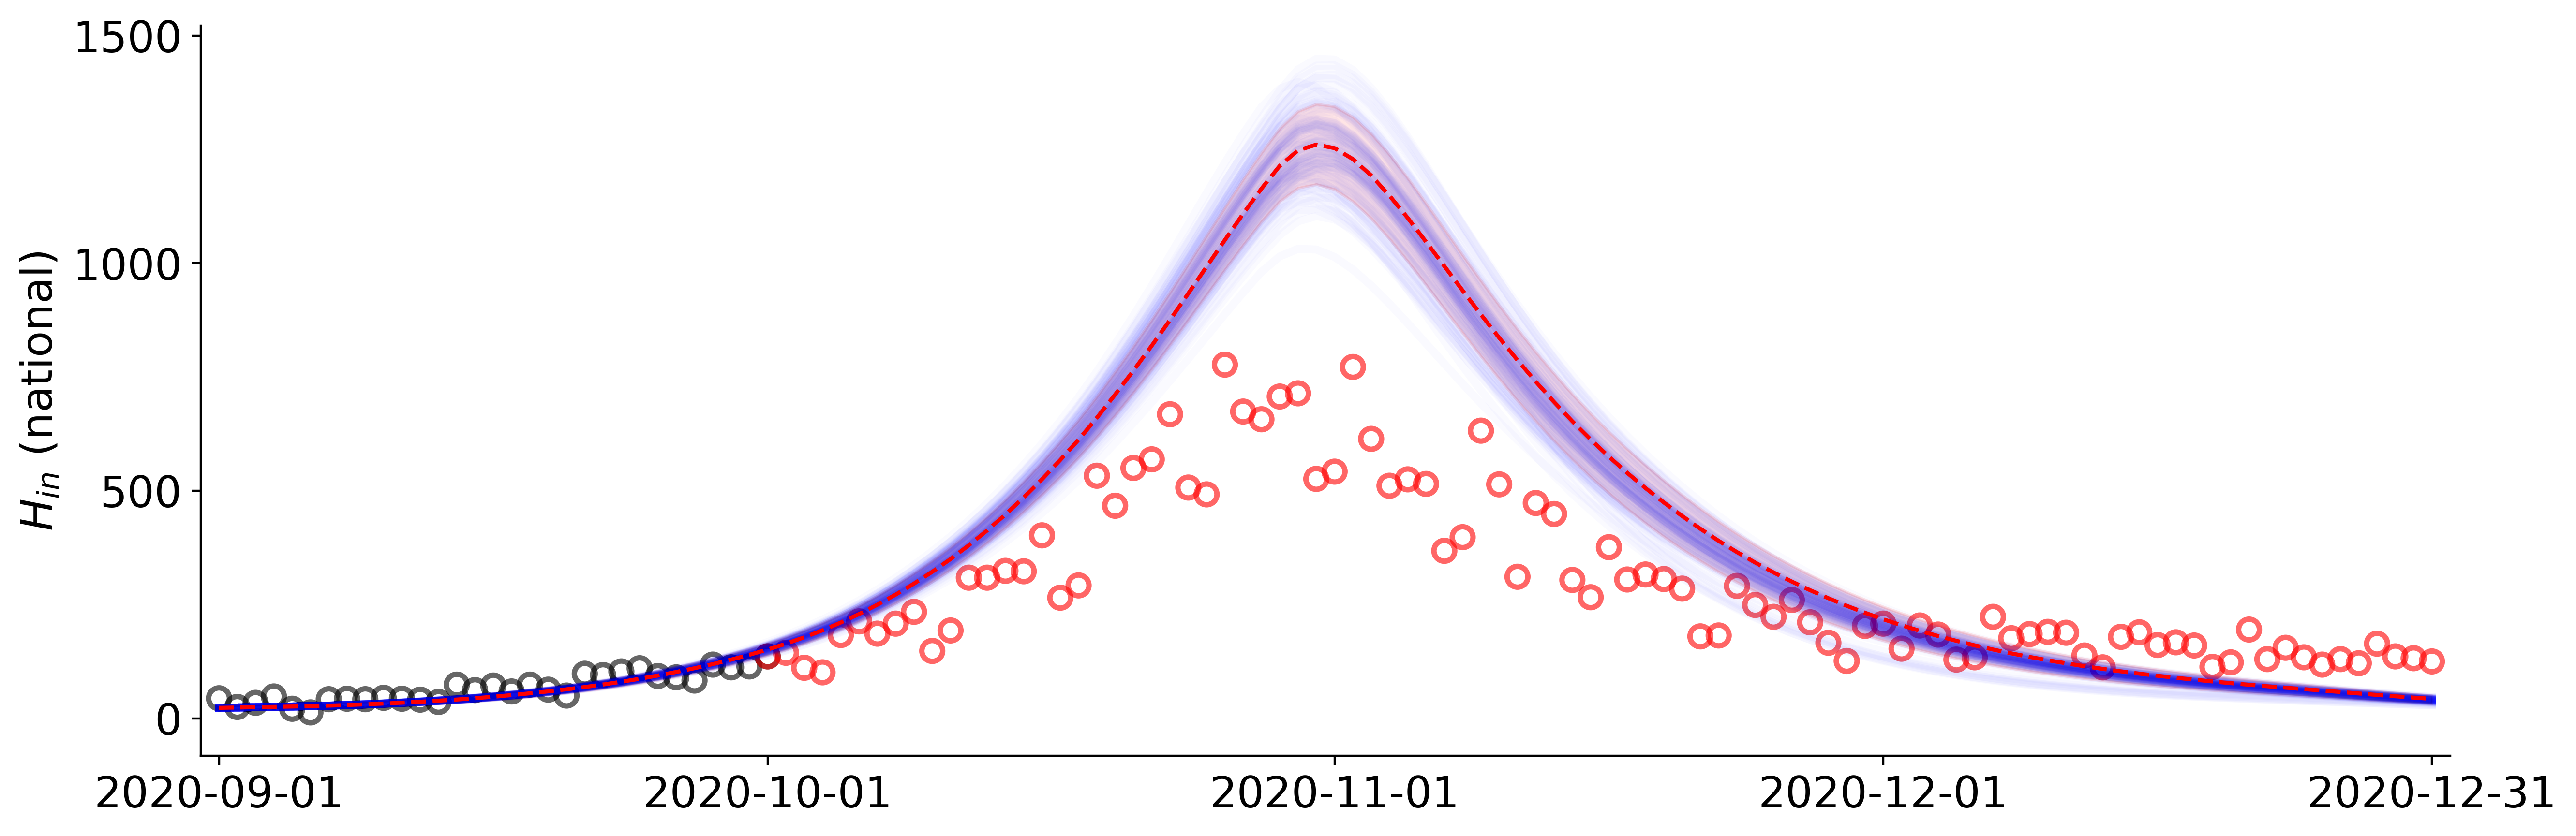

In [14]:
# Example of the effect of extrapolating a prediction with poor initial conditions.
# Black circles denote the data that was used for the calibration with initial conditions shown above
# Red circles are the actual data, which should correspond with the prediction, at least in the beginning.
# Nationally, it's still rather OK
Image(filename='../calibration/insufficient-calibration_national.png')

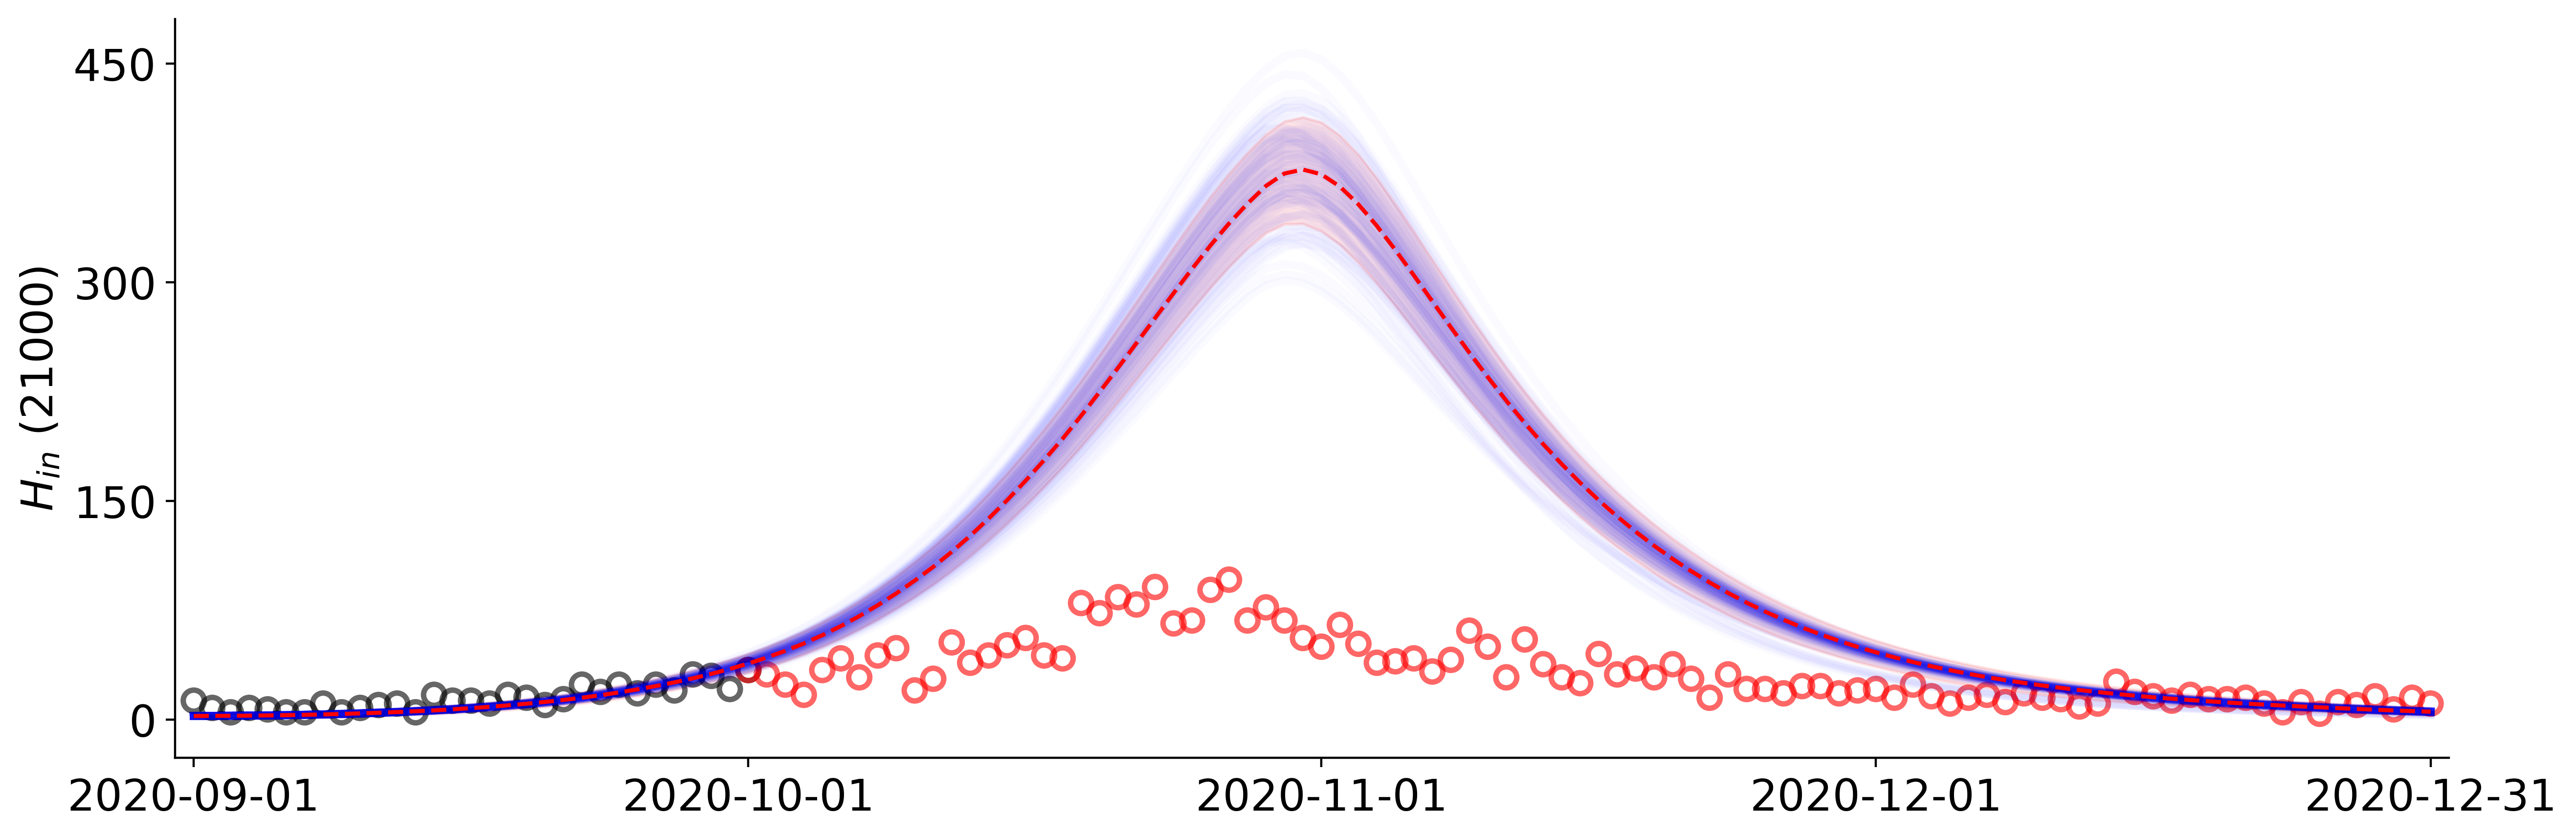

In [15]:
# Example of the effect of extrapolating a prediction with poor initial conditions.
# In this particular calibration, the situation is the worst for Brussels
Image(filename='../calibration/insufficient-calibration_21000.png')

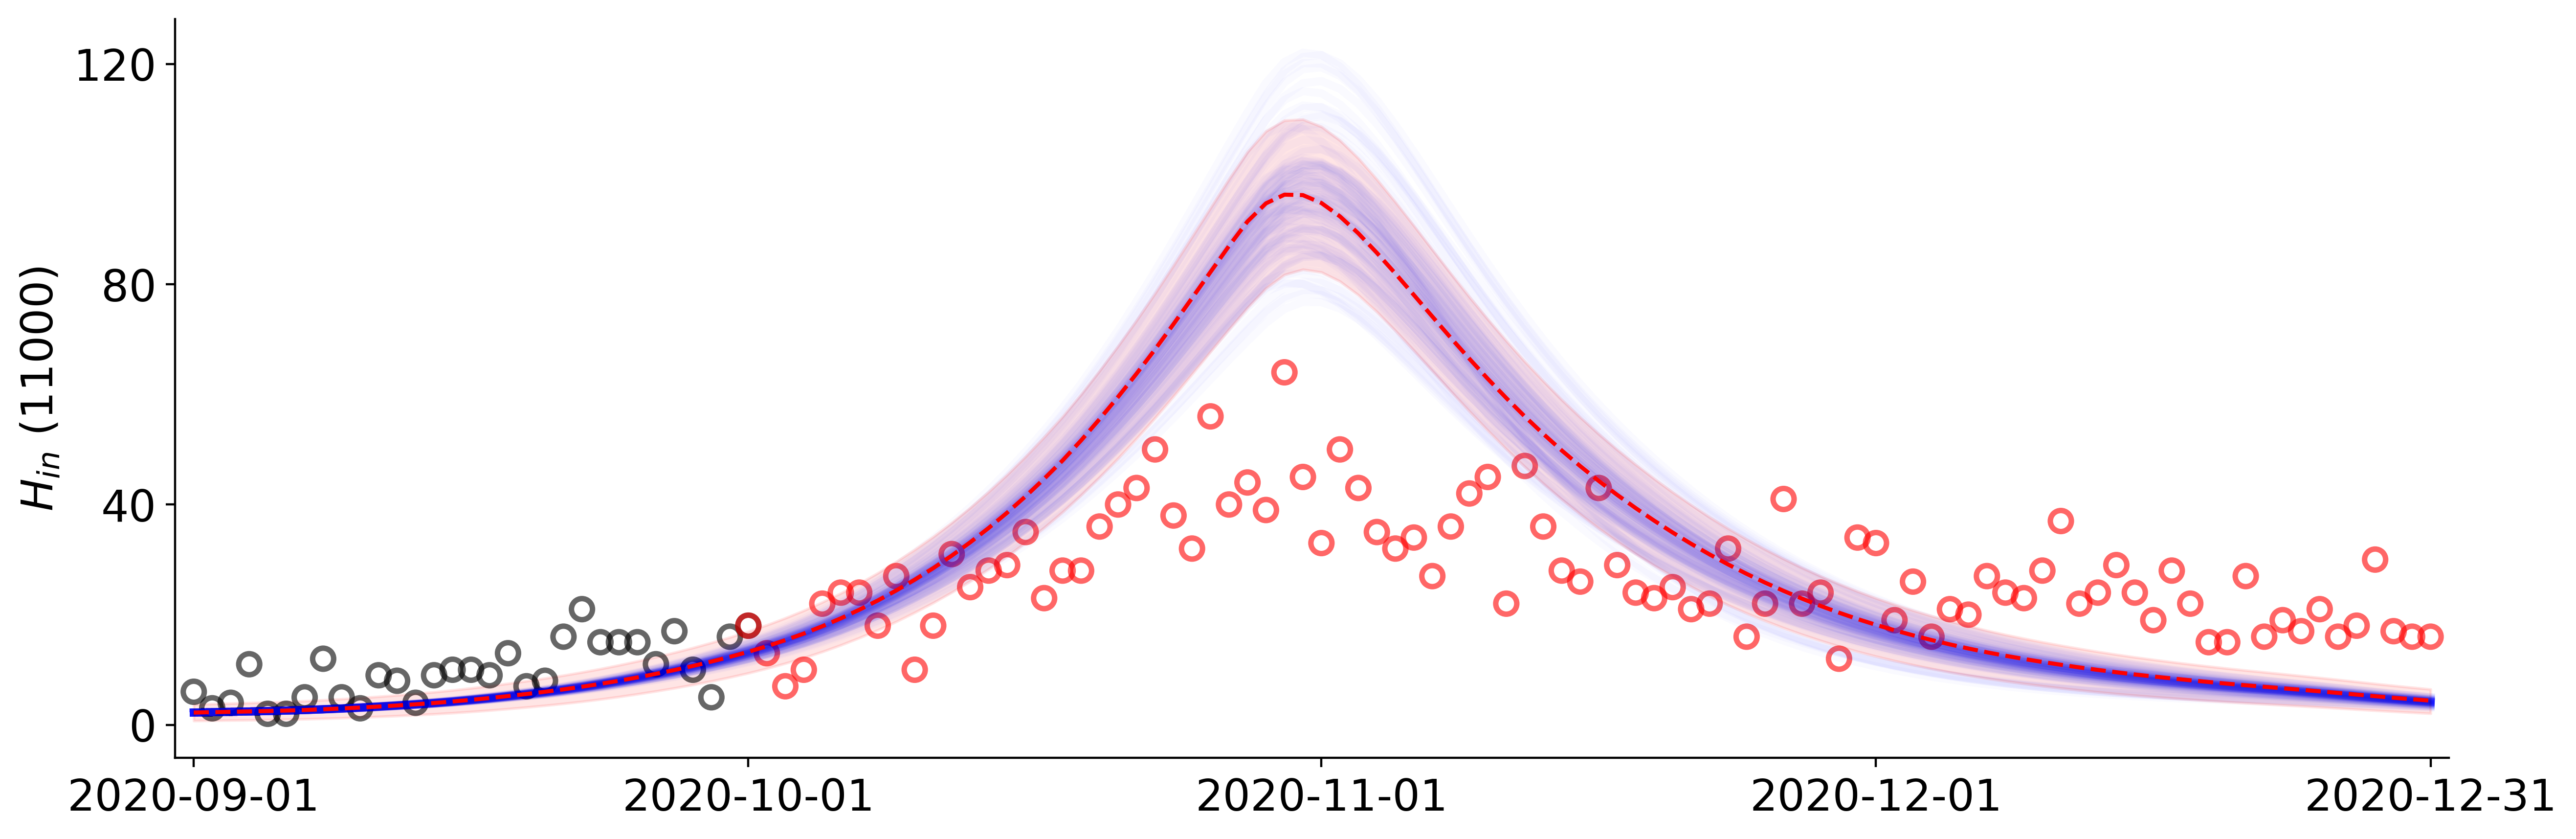

In [16]:
# Example of the effect of extrapolating a prediction with poor initial conditions.
# Antwerp is OK but still clearly almost double the number of daily hospitalisations is expected,
# which accumulates to a very large difference
Image(filename='../calibration/insufficient-calibration_11000.png')

## Solving the IC problem for the spatial SEIQRD model

This prediction can be made much better, and to do so, we will focus on establishing better initial conditions. For the spatially explicit model, this implies that we not only have to guide the social contact behaviour, but also that we must ...

**increase the number of exposed people at one particular time**

... which we will call "(local) exposure injection", because it is an articial way of injecting more infected people into the system than the coupled ODEs would naturally allow.

Effectively, we will manually find one or several moments $t^g$ per arrondissement at which we move $N_i^g$ subjects (of age class $i$) from the susceptible class $S^g_i$ to the exposed class $E^g_i$. Note that we will _not_ focus on differences between age classes and will generally choose an age distribution that corresponds to the national age distribution; doing otherwise would be too much of a hassle.

We will have to define a time-dependent function that co-defines the model, and that can do what's described above. There are several possible approaches:

1. Change the effective transmission rate coefficient $\beta^g$ by multiplying with another parameter $\epsilon^g(t)$ that defaults to 1 at all times except the user-defined times (see first figure below). This is the approach that is probably easiest to implement.

$$ \dot{S}_i^g = - \sum\limits_{h=1}^G P^{gh} S_i^g \epsilon^h(t) \beta^h \sum\limits_{j=1}^{N} N_{\text{c},ij}  \frac{(I_\text{presy})_{j,\text{eff}}^h + (I_\text{asy})_{j,\text{eff}}^h}{T_{j,\text{eff}}^g} + \zeta R^g_i $$

2. Manually move a number of susceptible individuals from the Susceptible pool to the Exposed pool at one particular day $t_0$

$$ \dot{S}_i^g = - \sum\limits_{h=1}^G P^{gh} S_i^g \beta^h \sum\limits_{j=1}^{N} N_{\text{c},ij}  \frac{(I_\text{presy})_{j,\text{eff}}^h + (I_\text{asy})_{j,\text{eff}}^h}{T_{j,\text{eff}}^g} + \zeta R^g_i - N^g H(t-t_0) H(t_0 + 1 - t) $$
where $H$ is the Heaviside function. In both cases, this function addition is mirrored in the expression for $\dot{E}_i^g$. Note that this may be generalised to stretch over more than one day by changing $H(t_0 + 1 - t) \rightarrow H(t_0 + t_1 - t)$.

Naturally, all these approaches will suffer from the fact that injecting more exposed individuals in one region $g$ will lead to increased exposures in a different place. Fixing a fit by hand will therefore be difficult, and one should (i) first try to fix the large regions, and (ii) always try to underestimate. In any case, a suboptimal result will be attained, because there are simply too many permutations.

Text(0.5, 0, 'Time (arbitrary units)')

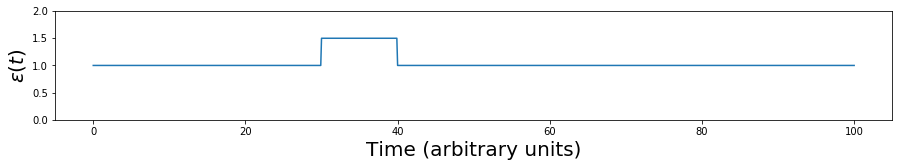

In [35]:
# Approach 1

import numpy as np
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,2))
t = np.linspace(0, 100, 1001)
epsilon = np.ones(len(t))
epsilon[300:400] = 1.5
ax.plot(t,epsilon)
ax.set_ylim(0, 2)
ax.set_yticks([0, .5, 1, 1.5, 2])
ax.set_ylabel(r'$\epsilon(t)$', size=20)
ax.set_xlabel('Time (arbitrary units)', size=20)

Text(0.5, 0, 'Time (days)')

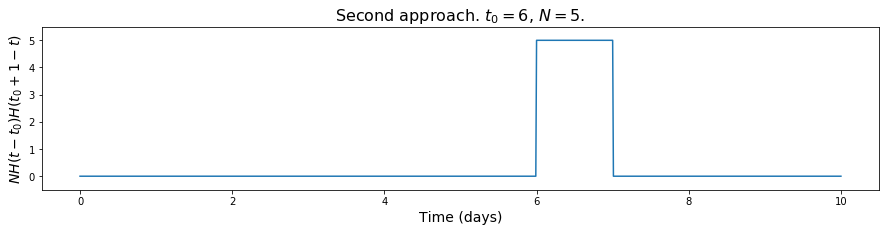

In [68]:
# Approach 2

fig, ax =  plt.subplots(figsize=(15,3))
t = np.linspace(0,10,1001)
t0 = 6
N = 5
# def heaviside(t):
#     Hlist = []
#     for elem in t:
#         if elem < 0:
#             Hlist.append(0)
#         else:
#             Hlist.append(1)
#     return np.array(Hlist)
ax.plot(t, N*np.heaviside(t-t0,1)*np.heaviside(t0+1-t,1))
ax.set_ylim(-0.1*N, N*(1 + .1))
# ax.set_yticks([0, N])
ax.set_title(r'Second approach. $t_0 = 6$, $N = 5$.', size=16)
ax.set_ylabel(r'$NH(t-t_0)H(t_0+1-t)$', size=14)
ax.set_xlabel('Time (days)', size=14)

The second approach seems simpler now that I think of it, so we'll focus on this first.

# Implementation of 2nd approach of local exposure injection

We need a couple of things:
- Copy the entire spatially explicit model class and rename it to `COVID19_SEIRD_spatial_fiddling`
- Define a heaviside function in 
- Change ODE formula in the `models.py` script
- Add two vector parameters $t_0^g$ and $N^g$ in `models.py` preamble
- Initiate this model
- Add these parameters to the `params` dictionary, but best not by default
- Use precisely the same parameter values as before, but now with the additional injected exposures
- Inspect what difference this makes for various permutations of locations, timings and quantities.
- Decide whether this method is sufficient

In [95]:
# Load packages
# Established packages
import os
import numpy as np
import matplotlib.pyplot as plt

# Custom package covid19model
from covid19model.models import models
from covid19model.data import model_parameters, mobility #, sciensano, google
from covid19model.visualization.output import population_status, infected, show_map, show_graphs
from covid19model.models.time_dependant_parameter_fncs import * # lockdown_func, mobility_update_func, policies_wave1_4prev

# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
# This may be useful because the `covid19model` package is under construction
%autoreload 2

# Spatial stratification
agg = 'arr'

In [96]:
# First define the double heaviside function

# copied from models.utils.py
def double_heaviside(t, t0, delta_t=None):
    """
    Function used to inject one additional exposed subjects per day at time t0 for delta_t days
    
    Parameters
    ----------
    t : float
        Time to be evaluated. Returns 1 only if t is within [t0, t0+delta_t] and 0 otherwise.
    t0 : array of floats
        Times at which new exposed individuals are injected in units of days since a particular start day. This is a G-dimensional array (one time per region)
    delta_t: array of floats
        Length of injection window in units of days. This is a G-dimensional array (one duration per region). Defaults to one day.
        
    Returns
    -------
    dh : array of floats
        G-dimensional array with values 0 or 1.
    
    """
    if delta_t is None:
        delta_t = np.ones(len(t0))
    if len(t0) != len(delta_t):
        raise Exception("Dimension of t0 and delta_t must be identical.")
    dh=[]
    for h in range(len(t0)):
        dh_h = np.heaviside(t-t0[h],1) * np.heaviside(t0[h]+delta_t[h]-t,1)
        dh.append(dh_h)
    return np.array(dh)

t0 = np.array([1,2,3,4])
for t in np.linspace(0,5,6):
    print(t, double_heaviside(t, t0))

0.0 [0. 0. 0. 0.]
1.0 [1. 0. 0. 0.]
2.0 [1. 1. 0. 0.]
3.0 [0. 1. 1. 0.]
4.0 [0. 0. 1. 1.]
5.0 [0. 0. 0. 1.]


In [112]:
# Next, we want the total number of injected subjects N per patch to be distributed over all ages.
# We do not want this age distribution to be user-defined, but simply demand that (1) it is proportional
# to the local age distribution of REGISTERED subjects, and (2) in every patch g it sums up to N[g]

# Load population distribution 
initN, Nc_all = model_parameters.get_integrated_willem2012_interaction_matrices(spatial=agg)
# Normalise such that every patch sums up to 1
initN_norm = initN / initN.sum(axis=1)[:, np.newaxis]
# Multiply with N such that every patch g sums up to N[g]
N = np.array(list(range(1,44,1))) # define some N
N_per_age = initN_norm * N[:,np.newaxis]

# Define random injection times
t0 = np.random.randint(1, 5, size=len(N))

In [119]:
# At any particular time, we obtain a matrix determining how many subjects per age class and per patch should be injected
# as exposures per day. Note that these are generally not whole numbers, but that's OK in our set of ODEs.
t = 2
N_per_age * double_heaviside(t,t0)[:,np.newaxis]

array([[0.11873946, 0.11199392, 0.12585276, 0.13499966, 0.12562681,
        0.13265219, 0.11198825, 0.07916248, 0.05898447],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.30777703, 0.31613422, 0.33493307, 0.37202093, 0.38566994,
        0.46136869, 0.38982595, 0.26093803, 0.17133214],
       [0.53762472, 0.4611908 , 0.59737904, 0.65694949, 0.57057677,
        0.46911033, 0.33077147, 0.21490739, 0.16149   ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.60851005, 0.64903911, 0.74617294, 0.75385928, 0.78351498,
        0.85355913, 0.72698051, 0.50654882, 0.37181518],
       [0.7474995 , 0.86576983, 0.83921935, 0.834823  , 0.93600792,
        0.98052308, 0.82909913, 0.58517951, 0.38187868],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
